In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("hw8.ipynb")

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# CPSC 330 - Applied Machine Learning

## Homework 8: Introduction to Computer vision and Time Series (Lectures 19 and 20) 

**Due date: see the [Mar 31, 11:59 pm](https://github.com/UBC-CS/cpsc330-2024W2?tab=readme-ov-file#deliverable-due-dates-tentative).**

## Imports

In [2]:
from hashlib import sha1

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import r2_score

<div class="alert alert-info">
    
## Submission instructions
<hr>
rubric={points:2}

Follow the [homework submission instructions](https://github.com/UBC-CS/cpsc330-2024W2/blob/main/docs/homework_instructions.md). 

**You may work in a group on this homework and submit your assignment as a group.** Below are some instructions on working as a group.  
- The maximum group size is 2. 
- Use group work as an opportunity to collaborate and learn new things from each other. 
- Be respectful to each other and make sure you understand all the concepts in the assignment well. 
- It's your responsibility to make sure that the assignment is submitted by one of the group members before the deadline. 
- You can find the instructions on how to do group submission on Gradescope [here](https://help.gradescope.com/article/m5qz2xsnjy-student-add-group-members).


When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`. 
2. Notebooks with cell execution numbers out of order will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
3. Upload the assignment using Gradescope's drag and drop tool. Check out this [Gradescope Student Guide](https://lthub.ubc.ca/guides/gradescope-student-guide/) if you need help with Gradescope submission.
4. Make sure that the plots and output are rendered properly in your submitted file. 
5. If the .ipynb file is too big and doesn't render on Gradescope, also upload a pdf or html in addition to the .ipynb.

<br><br>

## Exercise 1: time series prediction

In this exercise we'll be looking at a [dataset of avocado prices](https://www.kaggle.com/neuromusic/avocado-prices). You should start by downloading the dataset and storing it under the `data` folder. We will be forcasting average avocado price for the next week. 

In [3]:
df = pd.read_csv("data/avocado.csv", parse_dates=["Date"], index_col=0)
df.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


In [4]:
df.shape

(18249, 13)

In [5]:
df["Date"].min()

Timestamp('2015-01-04 00:00:00')

In [6]:
df["Date"].max()

Timestamp('2018-03-25 00:00:00')

It looks like the data ranges from the start of 2015 to March 2018 (~2 years ago), for a total of 3.25 years or so. Let's split the data so that we have a 6 months of test data.

In [7]:
split_date = '20170925'
df_train = df[df["Date"] <= split_date]
df_test  = df[df["Date"] >  split_date]

In [8]:
assert len(df_train) + len(df_test) == len(df)

<br><br>

<!-- BEGIN QUESTION -->

### 1.1 How many time series? 
rubric={points:4}

In the [Rain in Australia](https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package) dataset from lecture demo, we had different measurements for each Location. 

We want you to consider this for the avocado prices dataset. For which categorical feature(s), if any, do we have separate measurements? Justify your answer by referencing the dataset.

<div class="alert alert-warning">

Solution_1.1
    
</div>

_Points:_ 4

I would say that we have separate measurements for each different `region` and `type`. 

We have separate measurements for each different `region` because we can also have multiple measurements on the same day and type of avocados at different locations.

We have separate measurements for each different `type` because we can see that there can be multiple measurements on the same day and the same region for different types of avocados (conventional or organic). 

Put simply, we can choose to analyze the number of organic avocados sold at each region over time or the number of conventional avocados sold at each region over time. So when looking at it this way, we have two separate measurements for each location, one for conventional avocados and one for organic avocados.

In [9]:
df['region'].unique()

array(['Albany', 'Atlanta', 'BaltimoreWashington', 'Boise', 'Boston',
       'BuffaloRochester', 'California', 'Charlotte', 'Chicago',
       'CincinnatiDayton', 'Columbus', 'DallasFtWorth', 'Denver',
       'Detroit', 'GrandRapids', 'GreatLakes', 'HarrisburgScranton',
       'HartfordSpringfield', 'Houston', 'Indianapolis', 'Jacksonville',
       'LasVegas', 'LosAngeles', 'Louisville', 'MiamiFtLauderdale',
       'Midsouth', 'Nashville', 'NewOrleansMobile', 'NewYork',
       'Northeast', 'NorthernNewEngland', 'Orlando', 'Philadelphia',
       'PhoenixTucson', 'Pittsburgh', 'Plains', 'Portland',
       'RaleighGreensboro', 'RichmondNorfolk', 'Roanoke', 'Sacramento',
       'SanDiego', 'SanFrancisco', 'Seattle', 'SouthCarolina',
       'SouthCentral', 'Southeast', 'Spokane', 'StLouis', 'Syracuse',
       'Tampa', 'TotalUS', 'West', 'WestTexNewMexico'], dtype=object)

In [10]:
df['type'].unique()

array(['conventional', 'organic'], dtype=object)

In [11]:
df.sort_values(by=["Date","region"])

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
51,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.00,conventional,2015,Albany
51,2015-01-04,1.79,1373.95,57.42,153.88,0.00,1162.65,1162.65,0.00,0.00,organic,2015,Albany
51,2015-01-04,1.00,435021.49,364302.39,23821.16,82.15,46815.79,16707.15,30108.64,0.00,conventional,2015,Atlanta
51,2015-01-04,1.76,3846.69,1500.15,938.35,0.00,1408.19,1071.35,336.84,0.00,organic,2015,Atlanta
51,2015-01-04,1.08,788025.06,53987.31,552906.04,39995.03,141136.68,137146.07,3990.61,0.00,conventional,2015,BaltimoreWashington
...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,2018-03-25,1.55,1559967.20,121007.94,342853.10,1070.24,1093861.09,902774.79,190941.84,144.46,organic,2018,TotalUS
0,2018-03-25,0.93,7667064.46,2567279.74,1912986.38,118289.91,3068508.43,1309580.19,1745630.06,13298.18,conventional,2018,West
0,2018-03-25,1.60,271723.08,26996.28,77861.39,117.56,166747.85,87108.00,79495.39,144.46,organic,2018,West
0,2018-03-25,0.84,965185.06,438526.12,199585.90,11017.42,316055.62,153009.89,160999.10,2046.63,conventional,2018,WestTexNewMexico


<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 1.2 Equally spaced measurements? 
rubric={points:4}

In the Rain in Australia dataset, the measurements were generally equally spaced but with some exceptions. How about with this dataset? Justify your answer by referencing the dataset.

<div class="alert alert-warning">

Solution_1.2
    
</div>

_Points:_ 4

As mentioned in Question 1.1, we recognized two separate measurements for each region, and after looking at the dataset, we realized that this is represented by the fact that there are two rows of data for each region at any given time - one row for conventional avocados and one row for organic avocados.

In this data set, the measurements are **equally spaced out** when we look at it **with respect to each region and type**. We can see that there is a perfect 7-day period where data is collected in each region if we looked at the two types of avocados individually, because the time series data collects BOTH 'conventional' and 'organic' type avocados in each time data measurement in each region. Therefore, we can say that the measurements are evenly spaced out for ach type of avocado in each region.

To achieve this, I modified the way we get time spacing distribution by adding an additional parameter `type` that allows us to see the time difference between two time series data points at a specific location for a type of avocados.

In [12]:
df[df['region'] == "Atlanta"].sort_values(by=['Date'])

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
51,2015-01-04,1.00,435021.49,364302.39,23821.16,82.15,46815.79,16707.15,30108.64,0.00,conventional,2015,Atlanta
51,2015-01-04,1.76,3846.69,1500.15,938.35,0.00,1408.19,1071.35,336.84,0.00,organic,2015,Atlanta
50,2015-01-11,1.11,397542.72,330411.24,18958.22,1135.18,47038.08,21309.61,25728.47,0.00,conventional,2015,Atlanta
50,2015-01-11,1.84,3743.82,1613.69,1207.72,0.00,922.41,865.00,57.41,0.00,organic,2015,Atlanta
49,2015-01-18,1.11,431490.99,372236.92,18701.90,511.69,40040.48,16782.71,23257.77,0.00,conventional,2015,Atlanta
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2,2018-03-11,1.43,23042.99,590.29,5224.55,0.00,17228.15,16438.54,789.61,0.00,organic,2018,Atlanta
1,2018-03-18,1.48,19014.68,626.28,5411.88,0.00,12976.52,9134.72,3841.80,0.00,organic,2018,Atlanta
1,2018-03-18,0.95,730449.69,323507.79,36770.00,1828.28,368343.62,267740.12,97851.46,2752.04,conventional,2018,Atlanta
0,2018-03-25,1.04,624645.42,281209.40,33187.58,1831.33,308417.11,227944.75,77406.46,3065.90,conventional,2018,Atlanta


In [13]:
# from lecture 20
def plot_time_spacing_distribution_region(df, region="Albany", avo_type='conventional'):
    """
    Plots the distribution of time spacing for a given region.
    
    Parameters:
        df (pd.DataFrame): The input DataFrame with columns 'region' and 'Date'.
        region (str): The region (e.g., location) to analyze.
    """
    # Ensure 'Date' is in datetime format
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Filter data for the given region
    region_data = df[df['region'] == region]
    
    if region_data.empty:
        print(f"No data available for region: {region}")
        return

    region_type_data = region_data[region_data['type'] == avo_type]

    if region_type_data.empty:
        print(f"No data available for region: {region} and type : {avo_type}")
        return
    
    # Calculate time differences
    time_diffs = region_type_data['Date'].sort_values().diff().dropna()
    
    # Count the frequency of each time difference
    value_counts = time_diffs.value_counts().sort_index()
    
    # Display value counts
    print(f"Time spacing counts for {avo_type} avocadoes in {region}:\n{value_counts}\n")
    
    # Plot the bar chart
    plt.bar(value_counts.index.astype(str), value_counts.values, color='skyblue', edgecolor='black')
    plt.title(f"Time Difference Distribution for {avo_type} avocadoes in {region}")
    plt.xlabel("Time Difference (days)")
    plt.ylabel("Frequency")
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

Time spacing counts for conventional avocadoes in Atlanta:
Date
7 days    168
Name: count, dtype: int64



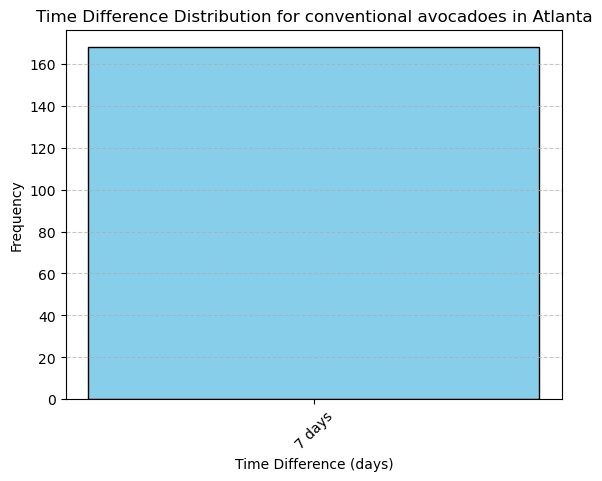

In [14]:
plot_time_spacing_distribution_region(df, 'Atlanta')

Time spacing counts for organic avocadoes in Atlanta:
Date
7 days    168
Name: count, dtype: int64



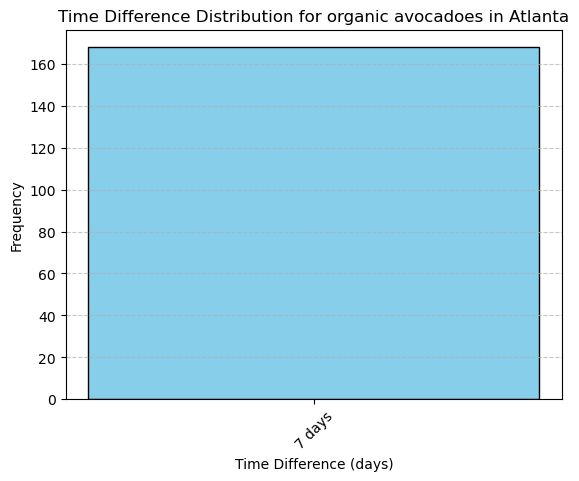

In [15]:
plot_time_spacing_distribution_region(df, 'Atlanta', 'organic')

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 1.3 Interpreting regions 
rubric={points:4}

In the Rain in Australia dataset, each location was a different place in Australia. For this dataset, look at the names of the regions. Do you think the regions are also all distinct, or are there overlapping regions? Justify your answer by referencing the data.

<div class="alert alert-warning">

Solution_1.3
    
</div>

_Points:_ 4

We can see that the regions in the data set are clearly **NOT** geographically distinct. The `region` feature covers cities like "Boston", to states like "California", to broad geographical regions like "MidSouth" and "West", to the whole country "TotalUS", which all overlap each other. Therefore, we cannot say that the regions are distinct, which is a unique characteristic of this dataset.

In [16]:
df['region'].unique()

array(['Albany', 'Atlanta', 'BaltimoreWashington', 'Boise', 'Boston',
       'BuffaloRochester', 'California', 'Charlotte', 'Chicago',
       'CincinnatiDayton', 'Columbus', 'DallasFtWorth', 'Denver',
       'Detroit', 'GrandRapids', 'GreatLakes', 'HarrisburgScranton',
       'HartfordSpringfield', 'Houston', 'Indianapolis', 'Jacksonville',
       'LasVegas', 'LosAngeles', 'Louisville', 'MiamiFtLauderdale',
       'Midsouth', 'Nashville', 'NewOrleansMobile', 'NewYork',
       'Northeast', 'NorthernNewEngland', 'Orlando', 'Philadelphia',
       'PhoenixTucson', 'Pittsburgh', 'Plains', 'Portland',
       'RaleighGreensboro', 'RichmondNorfolk', 'Roanoke', 'Sacramento',
       'SanDiego', 'SanFrancisco', 'Seattle', 'SouthCarolina',
       'SouthCentral', 'Southeast', 'Spokane', 'StLouis', 'Syracuse',
       'Tampa', 'TotalUS', 'West', 'WestTexNewMexico'], dtype=object)

In [17]:
...

Ellipsis

In [18]:
...

Ellipsis

<!-- END QUESTION -->

<br><br>

We will use the entire dataset despite any location-based weirdness uncovered in the previous part.

We will be trying to forecast the avocado price. The function below is adapted from [Lecture 19](https://github.com/UBC-CS/cpsc330-2024W2/tree/main/lectures), with some improvements.

In [19]:
def create_lag_feature(df, orig_feature, lag, groupby, new_feature_name=None, clip=False):
    """
    Creates a new feature that's a lagged version of an existing one.
    
    NOTE: assumes df is already sorted by the time columns and has unique indices.
    
    Parameters
    ----------
    df : pandas.core.frame.DataFrame
        The dataset.
    orig_feature : str
        The column name of the feature we're copying
    lag : int
        The lag; negative lag means values from the past, positive lag means values from the future
    groupby : list
        Column(s) to group by in case df contains multiple time series
    new_feature_name : str
        Override the default name of the newly created column
    clip : bool
        If True, remove rows with a NaN values for the new feature
    
    Returns
    -------
    pandas.core.frame.DataFrame
        A new dataframe with the additional column added.
        
    """
        
    if new_feature_name is None:
        if lag < 0:
            new_feature_name = "%s_lag%d" % (orig_feature, -lag)
        else:
            new_feature_name = "%s_ahead%d" % (orig_feature, lag)
    
    new_df = df.assign(**{new_feature_name : np.nan})
    for name, group in new_df.groupby(groupby):        
        if lag < 0: # take values from the past
            new_df.loc[group.index[-lag:],new_feature_name] = group.iloc[:lag][orig_feature].values
        else:       # take values from the future
            new_df.loc[group.index[:-lag], new_feature_name] = group.iloc[lag:][orig_feature].values
            
    if clip:
        new_df = new_df.dropna(subset=[new_feature_name])
        
    return new_df

We first sort our dataframe properly:

In [20]:
df_sort = df.sort_values(by=["region", "type", "Date"]).reset_index(drop=True)
df_sort

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,Albany
1,2015-01-11,1.24,41195.08,1002.85,31640.34,127.12,8424.77,8036.04,388.73,0.0,conventional,2015,Albany
2,2015-01-18,1.17,44511.28,914.14,31540.32,135.77,11921.05,11651.09,269.96,0.0,conventional,2015,Albany
3,2015-01-25,1.06,45147.50,941.38,33196.16,164.14,10845.82,10103.35,742.47,0.0,conventional,2015,Albany
4,2015-02-01,0.99,70873.60,1353.90,60017.20,179.32,9323.18,9170.82,152.36,0.0,conventional,2015,Albany
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18244,2018-02-25,1.57,18421.24,1974.26,2482.65,0.00,13964.33,13698.27,266.06,0.0,organic,2018,WestTexNewMexico
18245,2018-03-04,1.54,17393.30,1832.24,1905.57,0.00,13655.49,13401.93,253.56,0.0,organic,2018,WestTexNewMexico
18246,2018-03-11,1.56,22128.42,2162.67,3194.25,8.93,16762.57,16510.32,252.25,0.0,organic,2018,WestTexNewMexico
18247,2018-03-18,1.56,15896.38,2055.35,1499.55,0.00,12341.48,12114.81,226.67,0.0,organic,2018,WestTexNewMexico


We then call `create_lag_feature`. This creates a new column in the dataset `AveragePriceNextWeek`, which is the following week's `AveragePrice`. We have set `clip=True` which means it will remove rows where the target would be missing.

In [21]:
df_hastarget = create_lag_feature(df_sort, "AveragePrice", +1, ["region", "type"], "AveragePriceNextWeek", clip=True)
df_hastarget

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region,AveragePriceNextWeek
0,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,Albany,1.24
1,2015-01-11,1.24,41195.08,1002.85,31640.34,127.12,8424.77,8036.04,388.73,0.0,conventional,2015,Albany,1.17
2,2015-01-18,1.17,44511.28,914.14,31540.32,135.77,11921.05,11651.09,269.96,0.0,conventional,2015,Albany,1.06
3,2015-01-25,1.06,45147.50,941.38,33196.16,164.14,10845.82,10103.35,742.47,0.0,conventional,2015,Albany,0.99
4,2015-02-01,0.99,70873.60,1353.90,60017.20,179.32,9323.18,9170.82,152.36,0.0,conventional,2015,Albany,0.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18243,2018-02-18,1.56,17597.12,1892.05,1928.36,0.00,13776.71,13553.53,223.18,0.0,organic,2018,WestTexNewMexico,1.57
18244,2018-02-25,1.57,18421.24,1974.26,2482.65,0.00,13964.33,13698.27,266.06,0.0,organic,2018,WestTexNewMexico,1.54
18245,2018-03-04,1.54,17393.30,1832.24,1905.57,0.00,13655.49,13401.93,253.56,0.0,organic,2018,WestTexNewMexico,1.56
18246,2018-03-11,1.56,22128.42,2162.67,3194.25,8.93,16762.57,16510.32,252.25,0.0,organic,2018,WestTexNewMexico,1.56


Our goal is to predict `AveragePriceNextWeek`. 

Let's split the data:

In [22]:
df_train = df_hastarget[df_hastarget["Date"] <= split_date]
df_test  = df_hastarget[df_hastarget["Date"] >  split_date]

<br><br>

<!-- BEGIN QUESTION -->

### 1.4 `AveragePrice` baseline 
rubric={points}

Soon we will want to build some models to forecast the average avocado price a week in advance. Before we start with any ML though, let's try a baseline. Previously we used `DummyClassifier` or `DummyRegressor` as a baseline. This time, we'll do something else as a baseline: we'll assume the price stays the same from this week to next week. So, we'll set our prediction of "AveragePriceNextWeek" exactly equal to "AveragePrice", assuming no change. That is kind of like saying, "If it's raining today then I'm guessing it will be raining tomorrow". This simplistic approach will not get a great score but it's a good starting point for reference. If our model does worse that this, it must not be very good. 

Using this baseline approach, what $R^2$ do you get on the train and test data?

<div class="alert alert-warning">

Solution_1.4
    
</div>

_Points:_ 4

On the training set, we get a $R^2$ score of around 0.83. \
On the test set, we get a $R^2$ score of around 0.76. \
These scores are actually not horrible at all!

In [23]:
from sklearn.metrics import r2_score

train_r2 = r2_score(df_train['AveragePriceNextWeek'], df_train['AveragePrice'])

train_r2

0.8285800937261841

In [24]:
test_r2 = r2_score(df_test['AveragePriceNextWeek'], df_test['AveragePrice'])

test_r2

0.7631780188583048

In [25]:
assert not train_r2 is None, "Are you using the correct variable name?"
assert not test_r2 is None, "Are you using the correct variable name?"
assert sha1(str(round(train_r2, 3)).encode('utf8')).hexdigest() == 'b1136fe2a8918904393ab6f40bfb3f38eac5fc39', "Your training score is not correct. Are you using the right features?"
assert sha1(str(round(test_r2, 3)).encode('utf8')).hexdigest() == 'cc24d9a9b567b491a56b42f7adc582f2eefa5907', "Your test score is not correct. Are you using the right features?"

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 1.5 Forecasting average avocado price
rubric={points:10}

Now that the baseline is done, let's build some models to forecast the average avocado price a week later. Experiment with a few approachs for encoding the date. Justify the decisions you make. Which approach worked best? Report your test score and briefly discuss your results.

Benchmark: you should be able to achieve $R^2$ of at least 0.79 on the test set. I got to 0.80, but not beyond that. Let me know if you do better!

Note: because we only have 2 splits here, we need to be a bit wary of overfitting on the test set. Try not to test on it a ridiculous number of times. If you are interested in some proper ways of dealing with this, see for example sklearn's [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html), which is like cross-validation for time series data.

<div class="alert alert-warning">

Solution_1.5
    
</div>

_Points:_ 10

_Type your answer here, replacing this text._

In [26]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15441 entries, 0 to 18222
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Date                  15441 non-null  datetime64[ns]
 1   AveragePrice          15441 non-null  float64       
 2   Total Volume          15441 non-null  float64       
 3   4046                  15441 non-null  float64       
 4   4225                  15441 non-null  float64       
 5   4770                  15441 non-null  float64       
 6   Total Bags            15441 non-null  float64       
 7   Small Bags            15441 non-null  float64       
 8   Large Bags            15441 non-null  float64       
 9   XLarge Bags           15441 non-null  float64       
 10  type                  15441 non-null  object        
 11  year                  15441 non-null  int64         
 12  region                15441 non-null  object        
 13  AveragePriceNextWeek 

In [27]:
numeric_features = [
    "AveragePrice",
    "Total Volume",
    "4046",
    "4225",
    "4770",
    "Total Bags",
    "Small Bags",
    "Large Bags",
    "XLarge Bags",
    "year"
]
categorical_features = [
    "type",
    "region"
]
drop_features = ["Date"]
target = ["AveragePriceNextWeek"]

In [28]:
# from lecture 20
def preprocess_features(
    train_df,
    test_df,
    numeric_features,
    categorical_features,
    drop_features,
    target
):

    all_features = set(numeric_features + categorical_features + drop_features + target)
    if set(train_df.columns) != all_features:
        print("Missing columns", set(train_df.columns) - all_features)
        print("Extra columns", all_features - set(train_df.columns))
        raise Exception("Columns do not match")

    numeric_transformer = make_pipeline(
        SimpleImputer(strategy="median"), StandardScaler()
    )
    categorical_transformer = make_pipeline(
        SimpleImputer(strategy="constant", fill_value="missing"),
        OneHotEncoder(handle_unknown="ignore", sparse_output=False),
    )

    preprocessor = make_column_transformer(
        (numeric_transformer, numeric_features),
        (categorical_transformer, categorical_features),
        ("drop", drop_features),
    )
    preprocessor.fit(train_df)
    ohe_feature_names = (
        preprocessor.named_transformers_["pipeline-2"]
        .named_steps["onehotencoder"]
        .get_feature_names_out(categorical_features)
        .tolist()
    )
    new_columns = numeric_features + ohe_feature_names

    X_train_enc = pd.DataFrame(
        preprocessor.transform(train_df), index=train_df.index, columns=new_columns
    )
    X_test_enc = pd.DataFrame(
        preprocessor.transform(test_df), index=test_df.index, columns=new_columns
    )

    y_train = train_df["AveragePriceNextWeek"]
    y_test = test_df["AveragePriceNextWeek"]

    return X_train_enc, y_train, X_test_enc, y_test, preprocessor

In [29]:
# from lecture 20
def score_ridge_print_coeff(preprocessor, train_df, y_train, test_df, y_test, X_train_enc):
    ridge_pipe = make_pipeline(preprocessor, Ridge(max_iter=1000))
    ridge_pipe.fit(train_df, y_train)
    print("Train score: {:.2f}".format(ridge_pipe.score(train_df, y_train)))
    print("Test score: {:.2f}".format(ridge_pipe.score(test_df, y_test)))
    ridge_coef = pd.DataFrame(
        data=ridge_pipe.named_steps["ridge"].coef_.flatten(),
        index=X_train_enc.columns,
        columns=["Coef"],
    )
    return ridge_coef.sort_values(by="Coef", ascending=False)

In [30]:
first_day = df_train["Date"].min()

# days_since feature
df_train = df_train.assign(
    Days_since=df_train["Date"].apply(lambda x: (x - first_day).days)
)
df_test = df_test.assign(
    Days_since=df_test["Date"].apply(lambda x: (x - first_day).days)
)

# add month feature
df_train = df_train.assign(
    Month=df_train["Date"].apply(lambda x: x.month_name())
)  # x.month_name() to get the actual string
df_test = df_test.assign(Month=df_test["Date"].apply(lambda x: x.month_name()))

In [31]:
X_train_enc, y_train, X_test_enc, y_test, preprocessor = preprocess_features(
    df_train,
    df_test,
    numeric_features + ["Days_since"],
    categorical_features + ['Month'],
    drop_features,
    target
)

X_train_enc

,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,year,...,Month_December,Month_February,Month_January,Month_July,Month_June,Month_March,Month_May,Month_November,Month_October,Month_September
0,-0.432512,-0.234535,-0.229503,-0.222203,-0.214954,-0.232206,-0.229907,-0.223154,-0.172063,-1.147053,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.383676,-0.234440,-0.230948,-0.219448,-0.214272,-0.233587,-0.231513,-0.223789,-0.172063,-1.147053,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.554604,-0.233469,-0.231018,-0.219530,-0.214196,-0.229850,-0.226469,-0.224325,-0.172063,-1.147053,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.823205,-0.233283,-0.230996,-0.218170,-0.213945,-0.230999,-0.228629,-0.222193,-0.172063,-1.147053,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.994133,-0.225747,-0.230668,-0.196131,-0.213811,-0.232627,-0.229930,-0.224856,-0.172063,-1.147053,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18218,2.693027,-0.241780,-0.229664,-0.242429,-0.215395,-0.232066,-0.229029,-0.225402,-0.172063,1.376692,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18219,2.424426,-0.244264,-0.231008,-0.242114,-0.215395,-0.239735,-0.239057,-0.225344,-0.172063,1.376692,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
18220,2.400008,-0.243034,-0.230503,-0.241696,-0.215395,-0.236468,-0.234745,-0.225499,-0.172063,1.376692,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
18221,2.351171,-0.243442,-0.230278,-0.243130,-0.215395,-0.236393,-0.234638,-0.225529,-0.172063,1.376692,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [32]:
score_ridge_print_coeff(preprocessor, df_train, y_train, df_test, y_test, X_train_enc)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Train score: 0.85
Test score: 0.80


,Coef
AveragePrice,0.316943
year,0.247612
Month_September,0.112086
Month_October,0.100772
region_SanFrancisco,0.100081
...,...
region_Houston,-0.086358
Month_April,-0.087222
Month_February,-0.120834
Month_January,-0.179477


#### Great! We were able to get a test $R^2$ score of 0.8. It looks like turning the month in DateTime into a categorical variable and having the days since first day feature was really effective for our Ridge model!

<!-- END QUESTION -->

<br><br><br><br>

## Exercise 2: Short answer questions

<!-- BEGIN QUESTION -->

### 2.1 Time series

rubric={points:6}

The following questions pertain to Lecture 20 on time series data:

1. Sometimes a time series has missing time points or, worse, time points that are unequally spaced in general. Give an example of a real world situation where the time series data would have unequally spaced time points.
2. In class we discussed two approaches to using temporal information: encoding the date as one or more features, and creating lagged versions of features. Which of these (one/other/both/neither) two approaches would struggle with unequally spaced time points? Briefly justify your answer.
3. When studying time series modeling, we explored several ways to encode date information as a feature for the citibike dataset. When we used time of day as a numeric feature, the Ridge model was not able to capture the periodic pattern. Why? How did we tackle this problem? Briefly explain.

<div class="alert alert-warning">

Solution_2.1
    
</div>

_Points:_ 6

1. An example of this would be the occurrence of earthquakes in a specific region. There is no known pattern to the frequency of earthquakes, and it is definitely not periodic. Therefore, the time series data that records earthquakes would likely have unequally spaced data points as earthquakes do not occur periodically.
2. I would say that creating lagged versions of features can be tricky with unequally spaced time points. Since lag-based features are created by looking at data that is a certain time step ago (e.g. 1 week, 2 hours, 15 minutes, etc), it works effectively only if there is data for those backward shifts in constant time units, as in an equally spaced time series dataset. However, with unequally spaced time points, we don't have an effective amount of time step to "shift" in our time series to get the previous set of data, as we are uncertain about when the last occurrence happened.
3. The Ridge was not able to capture the periodic pattern when we used time of day as a numeric feature because a linear function can only learn a linear function of the time of day, not a periodic pattern like we want. We tackled this problem by using one-hot-encoding to encode the hours of the day as a categorical feature. This way, the Ridge model is able to use the one-hot-encoded categorical times of day feature to discover the periodic pattern in the time series data.

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 2.2 Computer vision 
rubric={points:6}

The following questions pertain to Lecture 19 on multiclass classification and introduction to computer vision. 

1. How many parameters (coefficients and intercepts) will `sklearn`’s `LogisticRegression()` model learn for a four-class classification problem, assuming that you have 10 features? Briefly explain your answer.
2. In Lecture 19, we briefly discussed how neural networks are sort of like `sklearn`'s pipelines, in the sense that they involve multiple sequential transformations of the data, finally resulting in the prediction. Why was this property useful when it came to transfer learning?
3. Imagine that you have a small dataset with ~1000 images containing pictures and names of 50 different Computer Science faculty members from UBC. Your goal is to develop a reasonably accurate multi-class classification model for this task. Describe which model/technique you would use and briefly justify your choice in one to three sentences.

<div class="alert alert-warning">

Solution_2.2
    
</div>

_Points:_ 6

1. The LogisticRegression will learn a coefficient for each feature in each class, plus a bias term for each class. Since we have 4 classes, we will have 10 coefficients for the features of each of the 4 classes, which gets us 40, plus a bias term for each class, which comes to 44 parameters total.
2. In transfer learning, we utilize a pre-trained model to help us extract the features in the image. Then, instead of using the pre-trained model's final classification layer, we replace that with our own LogiticRegression model with our dataset's labels for classification. This process is correlated with the concept of a pipeline because we can go into any point of the workflow and extract the result at that step, which is what we do in transfer learning by taking the extracted features from the pre-trained model's "pipeline" just before the final estimator step.
3. Since we only have a small dataset with ~1000 images, we don't have enough data to train our own deep-learning image classifier from scratch (which is probably not efficient anyways). Therefore, we can use feature extraction with a pre-trained image classifier (e.g. ResNet, VGG, etc...) and train a logistic regression model on the extracted features with our dataset. The pre-trained image classifiers identify important image features for us, so it does the "bulky" work for us and provides us with nice tabular feature values to work with in our logistic regression. The main reason why we use feature extraction is that our dataset is too small to build a deep-learning image classifier with, and it is computationally heavy to do so.

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 2.3 Survival analysis
<hr>

rubric={points:6}

The following questions pertain to Lecture 21 on survival analysis. We'll consider the use case of customer churn analysis.

1. What is the problem with simply labeling customers are "churned" or "not churned" and using standard supervised learning techniques?
2. Consider customer A who just joined last week vs. customer B who has been with the service for a year. Who do you expect will leave the service first: probably customer A, probably customer B, or we don't have enough information to answer? Briefly explain your answer. 
3. If a customer's survival function is almost flat during a certain period, how do we interpret that?

<div class="alert alert-warning">

Solution_2.3
    
</div>

_Points:_ 6

1. If we simply treated the problem as a binary classification and used standard supervised learning techniques, we will be exposing ourselves to the problems presented by right censoring. Right censoring is when the study ends before the occurrence of the event, and so we don't know the how long it actually takes until the occurrence of the event. In this case, it means that we don't have correct target values to train or test our model, which means we have incomplete information about the event.
2. According to the survival analysis we did and looking at the Kaplan-Meier curve, the survival rate for customer A (1 week with service) is higher than that of customer B (a year with service). Therefore, customer B would probably churn earlier than customer A because its customer A's survival rate is higher.
3. If a customer's survival function is almost flat, that means that the customer would have a close to 0% possibility of churning within that period of time, because the survival rate almost doesn't change within the time period.

<!-- END QUESTION -->

<br><br>

**Before submitting your assignment, please make sure you have followed all the instructions in the Submission instructions section at the top.** 

![](img/eva-well-done.png)